In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import math

In [6]:
%matplotlib notebook

In [7]:
yellow_values = [0.788, 0.721, 0.109]
blue_values = [0.113, 0.435, 0.701]
red_values = [1, 0, 0]
black_values = [0, 0, 0]
cough_color = [0.380, 0.058, 0.031]
width, height = 100, 100

In [8]:
line_x = []
line_y = []
line_y2 = []
line_y3 = []

In [9]:
class ParticleClass(object):

    def __init__(self, position_x, position_y, velocity_x, velocity_y, status, pid, colors):
        self.position_x = position_x
        self.position_y = position_y
        self.velocity_x = velocity_x
        self.velocity_y = velocity_y
        self.status = status
        self.pid = pid
        self.lifespan = 1000 # how long particles stay infected
        self.radius = 1
        self.colors = colors # default is blue
        self.cough_color = [1, 1, 1]
        self.cough = False

    def infect(self):
        self.colors = red_values
        self.status = 'infected'
        self.cough_color = black_values

    def heal(self):
        self.colors = yellow_values
        self.status = 'immune'

    def kill(self):
        self.colors = black_values
        self.velocity_x = 0
        self.velocity_y = 0
        self.status = 'dead'
        
#     def remove(self):
#         self.colors = [0, 0, 0]
#         self.velocity_x = 0
#         self.velocity_y = 0
#         self.position_x = 0
#         self.position_y = 0
        

In [10]:
def make_particle(status, id, color):
    x_val, y_val = random.randrange(0, width, 1), random.randrange(0, height, 1)
    x_vel, y_vel = random.uniform(-0.35, 0.35), random.uniform(-0.15, 0.15)
    return ParticleClass(x_val, y_val, x_vel, y_vel, status, id, color)

In [11]:
def collide(p1, p2):
    dx = p1.position_x - p2.position_x
    dy = p1.position_y - p2.position_y

    distance = math.hypot(dx, dy)
    return distance < (p1.radius + p2.radius)

In [12]:
def update_particles():

    posx = []
    posy = []
    colors = []
    sizes = []

    for i in range(0, len(my_particles)):

        if random.uniform(0, 1) < 0.015 and my_particles[i].status == 'infected':
            my_particles[i].radius = 2.5
            my_particles[i].cough = True

        if my_particles[i].cough:
            my_particles[i].radius -= 0.1
            if my_particles[i].radius <= 1:
                my_particles[i].cough = False

        # check for intersecting particles by creating nested for loop
        for j in range(0, len(my_particles)):
            # make sure we are not comparing the same particle
            if my_particles[i].pid != my_particles[j].pid:
                overlap = collide(my_particles[i], my_particles[j])

                # infected particles should only be able to infect non-infected ones
                # and not particles that are dead or immune
                if overlap and my_particles[i].status + \
                my_particles[j].status == 'infectednot_infected' \
                and my_particles[i].cough:
                    my_particles[i].infect()
                    my_particles[j].infect()

        # give particles velocity
        my_particles[i].position_x += my_particles[i].velocity_x
        my_particles[i].position_y += my_particles[i].velocity_y

        # change position and velocity when particles hit walls
        # right wall boundaries.
        if my_particles[i].position_x + my_particles[i].radius > width:
            my_particles[i].position_x = width - my_particles[i].radius
            my_particles[i].velocity_x *= -1

        # left wall boundaries.
        if my_particles[i].position_x - my_particles[i].radius < 0:
            my_particles[i].position_x = my_particles[i].radius
            my_particles[i].velocity_x *= -1

        # bottom wall boundaries.
        if my_particles[i].position_y - my_particles[i].radius < 0:
            my_particles[i].position_y = my_particles[i].radius
            my_particles[i].velocity_y *= -1

        # top wall boundaries.
        if my_particles[i].position_y >= height:
            my_particles[i].position_y = height - my_particles[i].radius
            my_particles[i].velocity_y *= -1

        # decriment lifespan of infection and then heal or kill infected (red) particles
        if my_particles[i].status == 'infected':
            my_particles[i].lifespan -= 1
            # kill 4 percent of infected particles
            if my_particles[i].lifespan == 0 and my_particles[i].pid < population_size * 0.04:
                my_particles[i].kill()
            elif my_particles[i].lifespan == 0:
                my_particles[i].heal()

        posx.append(my_particles[i].position_x)
        posy.append(my_particles[i].position_y)
        colors.append(my_particles[i].colors)
        sizes.append((my_particles[i].radius**2) * math.pi * 12)

        # set x y coordinates and particle colors for our scatter plots
    particle_scat.set_offsets(np.vstack((posx, posy)).T)
    particle_scat.set_color(colors)
    particle_scat.set_sizes(sizes)

    return particle_scat

In [13]:
def population_data():
    counter = counter2 = counter3 = counter4 = 0
    for particle in my_particles:
        if particle.status == 'infected':
            counter += 1
        elif particle.status == 'immune':
            counter2 += 1
        elif particle.status == 'dead':
            counter3 += 1

    stats = [round(counter/population_size, 2), round(counter2/population_size, 2),
             round(counter3/population_size, 2)]

    return stats

In [14]:
def animate(i):

    line_x.append(i)
    scatter_particles = update_particles()
    percentages = population_data()
    line_y.append(percentages[0])
    line_y2.append(percentages[1])
    line_y3.append(percentages[2])


    ax2.set_xlim(0, i)
    lines = [line[0][0].set_data(line_x, line_y), line[1][0].set_data(line_x, line_y2),
             line[2][0].set_data(line_x, line_y3)]

    return scatter_particles, lines

In [15]:
my_particles = []
unique_id = 0
# change this for different population size
population_size = 100
# create a ton of particles for graphing
for num in range(population_size + 1):
    # give each particle a unique id so we can check for collisions later
    if num == 5:
        # this will be our patient zero we are giving it red id and
        my_particles.append(make_particle('infected', num, red_values))
    else:
        my_particles.append(make_particle('not_infected', num, blue_values))

<IPython.core.display.Javascript object>


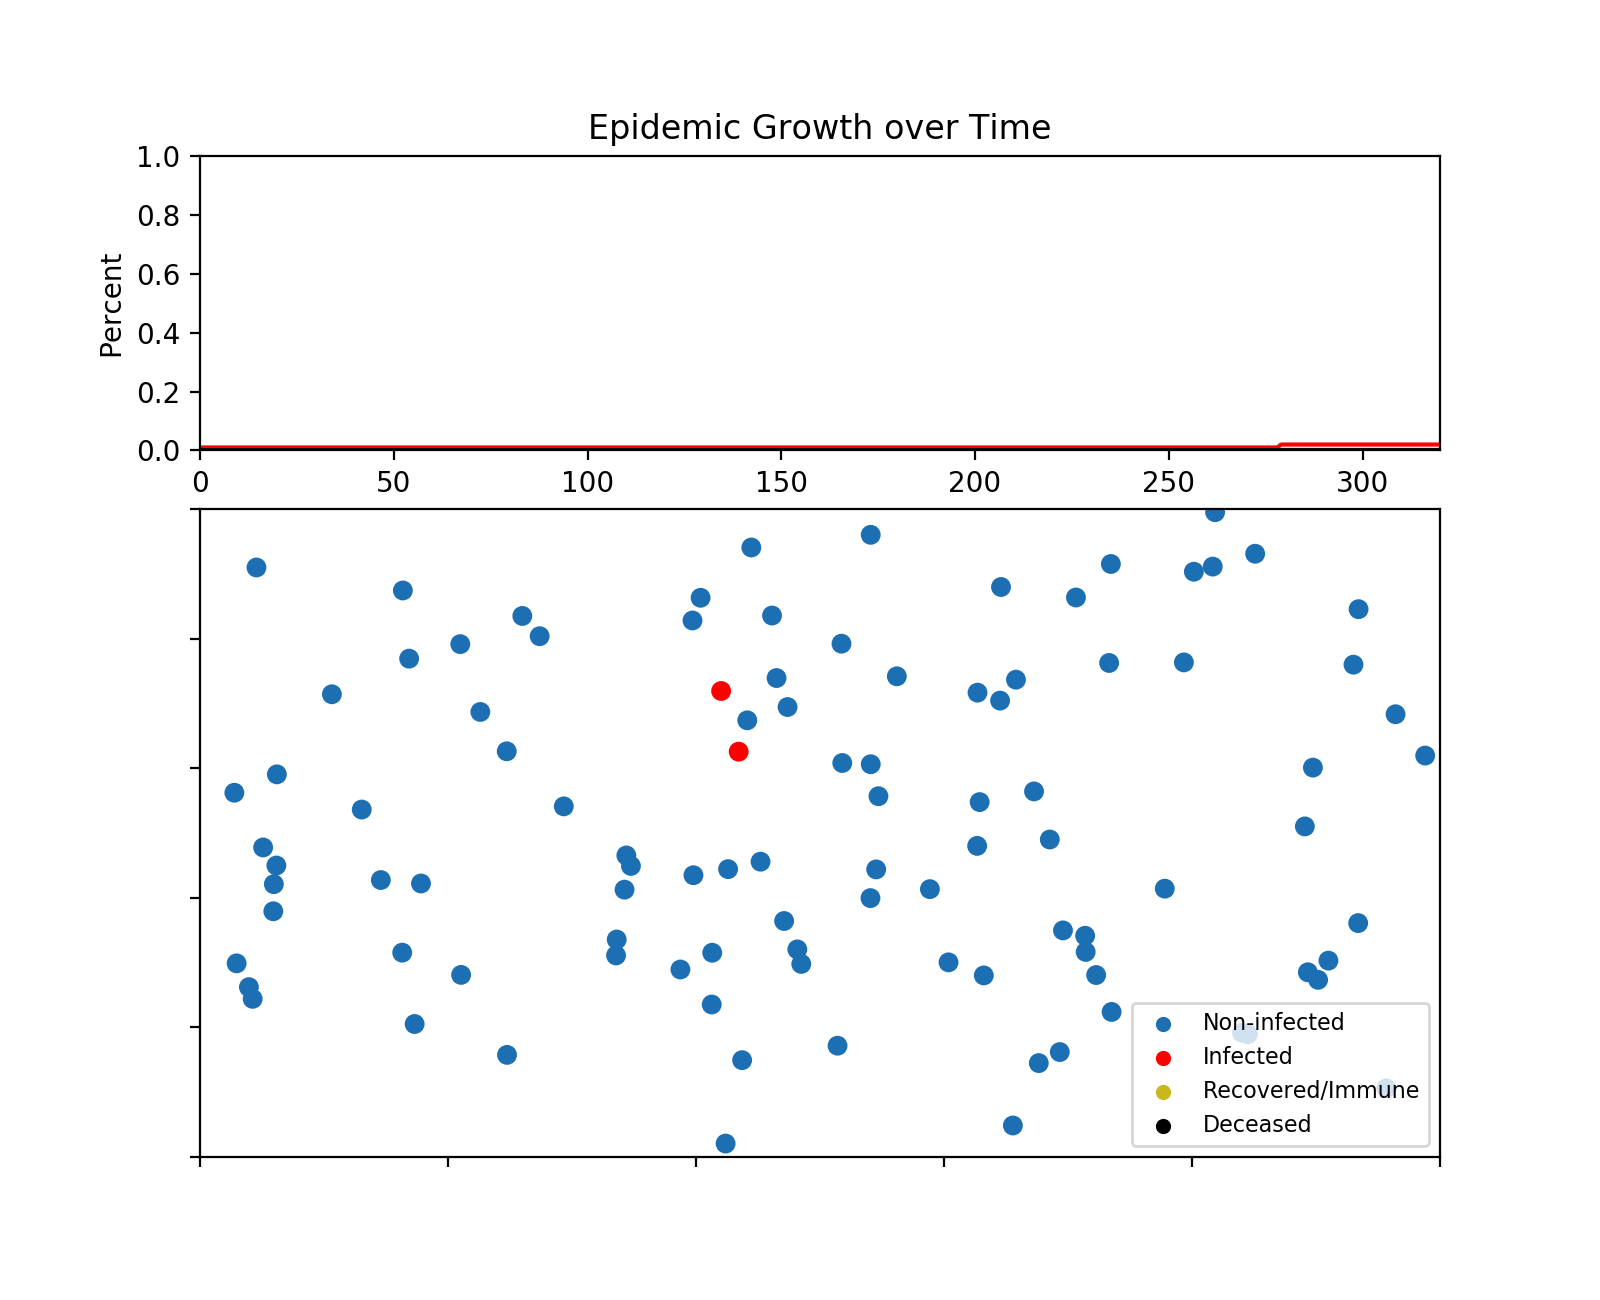

In [16]:
fig = plt.figure()
ax2 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Percent")
line = plt.plot(0, 0), plt.plot(0, 0), plt.plot(0, 0), plt.plot(0, 0)

line[0][0].set_color(red_values)
line[1][0].set_color(yellow_values)
line[2][0].set_color(black_values)

plt.title('Epidemic Growth over Time')

ax = plt.subplot2grid((3, 1), (1, 0), rowspan=2, colspan=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(0, width)
ax.set_ylim(0, height)
particle_scat = ax.scatter(0, 0)

# create dummy values for legend
red_dot = ax.scatter(-2, 0, s=20, linewidth=1, c=np.array(red_values).reshape(1,3))
blue_dot = ax.scatter(-2, 0, s=20, linewidth=1, c=np.array(blue_values).reshape(1, 3))
yellow_dot = ax.scatter(-2, 0, s=20, linewidth=1, c=np.array(yellow_values).reshape(1, 3))
black_dot = ax.scatter(-2, 0, s=20, linewidth=1, c='black')

# create legend
plt.legend(handles=[blue_dot, red_dot, yellow_dot, black_dot],
           labels=['Non-infected', 'Infected', 'Recovered/Immune',
                   'Deceased'], loc="lower right", fontsize=8)

# stylize graph
fig.set_size_inches(8.0, 6.5, forward=True)

# graph
scat_ani = FuncAnimation(fig, func=animate, interval=10, blit=False)

plt.show()